**Import necessary packages**

In [1]:
from pyspark.sql import SQLContext
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline, Transformer
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.param.shared import HasOutputCols, Param, Params
from pyspark.sql.functions import monotonically_increasing_id

from sklearn.preprocessing import RobustScaler

import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
import datetime

from sklearn import preprocessing

# Keras / Deep Learning
"""
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from keras.optimizers import Adam
"""

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Elephas for Deep Learning on Spark
from elephas.ml_model import ElephasEstimator
import numpy as np

ModuleNotFoundError: No module named 'pyspark'

**Custom Transformer**

In [2]:
# CUSTOM TRANSFORMER ----------------------------------------------------------------
class ModelPredict(Transformer, HasOutputCols, DefaultParamsReadable, DefaultParamsWritable,):
    """
    A custom Transformer which drops all columns that have at least one of the
    words from the banned_list in the name.
    """

    def __init__(self, inputCol,outputCol):
        #super(ColumnDropper, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol
        print("Load model...")
        self.model = load_model("Model/20201231_233317_MEM_used_stack_LSTM_0.59MAE_1.62RMSE.h5")
        print("Done")
        
    #def _fit(self, dataset):
        

    def _transform(self, df) :
        #df = df.drop(*[x for x in df.columns if any(y in x for y in self.banned_list)])
        #df = df.na.drop()
        #Input = np.array(self.df[self.inputCol].values)
        #self.output = self.model.model_predict(Input)
        #print(self.inputCol)
        
        data = df.select(self.inputCol).collect()
        #print(data)
        #print(len(data))
        input_data = np.array(data)
        #print(input_data.shape)
        input_data = np.reshape(input_data,(1,input_data.shape[0],1))
        #print("( %d , %d , %d)"%(input_data.shape[0],input_data.shape[1],input_data.shape[2]))
        output = self.model.predict(input_data)
        #print(output)
        #return  df.withColumn("pred",df[self.inputCol])
        return output
    
class MyRobust(Transformer, HasOutputCols, DefaultParamsReadable, DefaultParamsWritable,):
    """
    A custom Transformer which drops all columns that have at least one of the
    words from the banned_list in the name.
    """

    def __init__(self, inputCol,outputCol):
        #super(ColumnDropper, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol
                

    def _transform(self, df) :
        #df = df.drop(*[x for x in df.columns if any(y in x for y in self.banned_list)])
        #df = df.na.drop()
        #Input = np.array(self.df[self.inputCol].values)
        #self.output = self.model.model_predict(Input)
        #print(self.outputCol)
        
        data = df.select(self.inputCol).collect()
        
        input_data = np.array(data)
        
        input_data = np.reshape(input_data,(input_data.shape[0],1))
        sc = RobustScaler()
        scaled_data = sc.fit_transform(input_data)
        scaled_data_pandas = pd.DataFrame(scaled_data, columns=[self.outputCol])
        #print(scaled_data_pandas.shape[0])
        scaled_data_df = spark.createDataFrame(scaled_data_pandas, [self.outputCol])
        scaled_data_df.count()
        scaled_data_df = scaled_data_df.withColumn("row_id",monotonically_increasing_id())
        df = df.withColumn("row_id",monotonically_increasing_id())
        df.show(60)
        #print(scaled_data_df.count())
        #print(scaled_data_df.count())
        #print("( %d , %d , %d)"%(input_data.shape[0],input_data.shape[1],input_data.shape[2]))
        df = df.join(scaled_data_df, ("row_id")).drop("row_id")
        #result_df.show(60)
        #print(df.count())
        #print(output)
        
        return  df
        #return output





**Select Features**

In [3]:
# Helper function to select features to scale given their skew
def select_features_to_scale(df, drop_cols=['timestamp','id']):
    
    # Empty Selected Feature List for Output
    selected_features = []
    
    
    # Select Features to Scale based on Inputs ('in32' type, drop 'ID' columns or others, skew bounds)
    feature_list = list(df.toPandas().columns.drop(drop_cols))
    
    # Loop through 'feature_list' to select features based on Kurtosis / Skew
    for feature in feature_list:

        selected_features.append(feature)
        #if df.toPandas()[feature].kurtosis() < -2 or df.toPandas()[feature].kurtosis() > 2:
            
            
    
    # Return feature list to scale
    return selected_features

**Read RDS CPU utilization dataset**

In [4]:
%%time


df = spark.read.csv("hdfs://master:9000/user/data/rds_cpu_utilization_e47b3b.csv", inferSchema=True, header=True)
# inferSchema referring to the type of the column
df.show()
Data = df.collect()
Orgin_data = []

df = df.withColumn("id",monotonically_increasing_id())

for i in Data:
    Orgin_data.append(i[1])
    


+-------------------+------------------+
|          timestamp|             value|
+-------------------+------------------+
|2014-04-10 00:02:00|            14.012|
|2014-04-10 00:07:00|13.334000000000001|
|2014-04-10 00:12:00|              15.0|
|2014-04-10 00:17:00|            13.998|
|2014-04-10 00:22:00|            14.332|
|2014-04-10 00:27:00|            15.002|
|2014-04-10 00:32:00|13.984000000000002|
|2014-04-10 00:37:00|14.674000000000001|
|2014-04-10 00:42:00|            14.668|
|2014-04-10 00:47:00|13.665999999999999|
|2014-04-10 00:52:00|13.334000000000001|
|2014-04-10 00:57:00|            15.046|
|2014-04-10 01:02:00|            13.332|
|2014-04-10 01:07:00|              15.0|
|2014-04-10 01:12:00|              15.0|
|2014-04-10 01:17:00|            14.368|
|2014-04-10 01:22:00|13.665999999999999|
|2014-04-10 01:27:00|            15.332|
|2014-04-10 01:32:00|14.334000000000001|
|2014-04-10 01:37:00|14.335999999999999|
+-------------------+------------------+
only showing top

**Define Pipeline Stages**

In [5]:
stages = []
pred_value = []
unscaled_features = select_features_to_scale(df=df)
#stage
unscaled_assembler = VectorAssembler(inputCols=unscaled_features, outputCol="unscaled_features")
scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="unscaled_features", outputCol="scaled_features")
#scaler = MyRobust(inputCol="unscaled_features", outputCol="scaled_features")
pred = ModelPredict(inputCol="scaled_features",outputCol="pred_value")



stages += [unscaled_assembler, scaler, pred]

Load model...
Done


**Fit Dataframe and Transform another Dataframe**

In [6]:
def get_scaler(orgin_list):
    orgin_array = np.array(orgin_list)
    data_scaler_minmax = preprocessing.MinMaxScaler(feature_range=(0, 1))
    data_scaled_minmax = data_scaler_minmax.fit_transform(orgin_array[:,1:2])
    
    return data_scaler_minmax

def inverse_data(df_transform,win_scaler):
    return win_scaler.inverse_transform(df_transform)


In [7]:
pipeline = Pipeline(stages=stages)
diff_data_list = []
pred_value = []
for i in range(0,df.count()-60):
    window_df = df.filter(df.id.between(i,i+60-1))
    test = window_df.collect()
    
    
    window_scaler = get_scaler(test)
    #print(pred_time['timestamp'].show())
    #print(test[-1][0] + datetime.timedelta(minutes= 3))
    # Set Pipeline
    pred_time = test[-1][0] + datetime.timedelta(minutes= 3)
    #print(window_df.count())
    # Fit Pipeline to Data
    pipeline_model = pipeline.fit(window_df)

    # Transform Data using Fitted Pipeline
    df_transform = pipeline_model.transform(window_df)
    df_transform = inverse_data(df_transform,window_scaler)
    print("{}.Pred_value : {}".format(i,df_transform))
    df_transform = np.reshape(df_transform,(df_transform.shape[0]))
    pred_value.append(df_transform)
    diff_data = abs(df_transform-pred_value[i-1])
    diff_data_list.append(diff_data)
    print("{}.Diff_value : {}".format(i,diff_data))
    if diff_data >= 1:
        print("Warning : time:{} value:{}".format(pred_time,diff_data))

0.Pred_value : [[13.860018]]
0.Diff_value : [0.]
1.Pred_value : [[13.831706]]
1.Diff_value : [0.02831173]
2.Pred_value : [[13.798212]]
2.Diff_value : [0.033494]
3.Pred_value : [[13.767983]]
3.Diff_value : [0.03022861]
4.Pred_value : [[13.769469]]
4.Diff_value : [0.00148582]
5.Pred_value : [[13.788784]]
5.Diff_value : [0.01931477]
6.Pred_value : [[13.761993]]
6.Diff_value : [0.02679062]
7.Pred_value : [[13.766116]]
7.Diff_value : [0.00412273]
8.Pred_value : [[13.787139]]
8.Diff_value : [0.0210228]
9.Pred_value : [[13.871566]]
9.Diff_value : [0.08442688]
10.Pred_value : [[13.901415]]
10.Diff_value : [0.02984905]
11.Pred_value : [[13.899113]]
11.Diff_value : [0.00230217]
12.Pred_value : [[13.933403]]
12.Diff_value : [0.03429031]
13.Pred_value : [[13.98518]]
13.Diff_value : [0.05177689]
14.Pred_value : [[13.960118]]
14.Diff_value : [0.02506161]
15.Pred_value : [[13.922022]]
15.Diff_value : [0.03809643]
16.Pred_value : [[13.906014]]
16.Diff_value : [0.01600742]
17.Pred_value : [[13.908738]]

139.Pred_value : [[13.976639]]
139.Diff_value : [0.01170731]
140.Pred_value : [[13.902726]]
140.Diff_value : [0.07391262]
141.Pred_value : [[13.869501]]
141.Diff_value : [0.03322506]
142.Pred_value : [[13.80571]]
142.Diff_value : [0.06379128]
143.Pred_value : [[13.730534]]
143.Diff_value : [0.07517624]
144.Pred_value : [[13.65505]]
144.Diff_value : [0.07548332]
145.Pred_value : [[13.612791]]
145.Diff_value : [0.04225922]
146.Pred_value : [[13.592656]]
146.Diff_value : [0.02013493]
147.Pred_value : [[13.559468]]
147.Diff_value : [0.03318787]
148.Pred_value : [[13.491614]]
148.Diff_value : [0.06785393]
149.Pred_value : [[13.549971]]
149.Diff_value : [0.05835629]
150.Pred_value : [[13.6191435]]
150.Diff_value : [0.06917286]
151.Pred_value : [[13.689579]]
151.Diff_value : [0.07043552]
152.Pred_value : [[13.754914]]
152.Diff_value : [0.06533527]
153.Pred_value : [[13.811663]]
153.Diff_value : [0.05674839]
154.Pred_value : [[13.779831]]
154.Diff_value : [0.03183174]
155.Pred_value : [[13.753

274.Pred_value : [[13.832188]]
274.Diff_value : [0.02412415]
275.Pred_value : [[13.859582]]
275.Diff_value : [0.02739429]
276.Pred_value : [[13.8566065]]
276.Diff_value : [0.00297546]
277.Pred_value : [[13.839698]]
277.Diff_value : [0.01690865]
278.Pred_value : [[13.788132]]
278.Diff_value : [0.05156612]
279.Pred_value : [[13.749162]]
279.Diff_value : [0.03896999]
280.Pred_value : [[13.7165165]]
280.Diff_value : [0.03264523]
281.Pred_value : [[13.693576]]
281.Diff_value : [0.02294064]
282.Pred_value : [[13.677971]]
282.Diff_value : [0.01560497]
283.Pred_value : [[13.667818]]
283.Diff_value : [0.01015282]
284.Pred_value : [[13.606759]]
284.Diff_value : [0.061059]
285.Pred_value : [[13.605]]
285.Diff_value : [0.00175953]
286.Pred_value : [[13.580649]]
286.Diff_value : [0.02435017]
287.Pred_value : [[13.655889]]
287.Diff_value : [0.07523918]
288.Pred_value : [[13.697356]]
288.Diff_value : [0.04146767]
289.Pred_value : [[13.690434]]
289.Diff_value : [0.00692177]
290.Pred_value : [[13.68437

409.Pred_value : [[13.535067]]
409.Diff_value : [0.01277828]
410.Pred_value : [[13.535702]]
410.Diff_value : [0.00063515]
411.Pred_value : [[13.6046095]]
411.Diff_value : [0.06890774]
412.Pred_value : [[13.563972]]
412.Diff_value : [0.04063702]
413.Pred_value : [[13.523167]]
413.Diff_value : [0.04080582]
414.Pred_value : [[13.511585]]
414.Diff_value : [0.01158142]
415.Pred_value : [[13.517143]]
415.Diff_value : [0.00555801]
416.Pred_value : [[13.504648]]
416.Diff_value : [0.01249504]
417.Pred_value : [[13.483333]]
417.Diff_value : [0.02131557]
418.Pred_value : [[13.465598]]
418.Diff_value : [0.01773453]
419.Pred_value : [[13.441639]]
419.Diff_value : [0.02395916]
420.Pred_value : [[13.41891]]
420.Diff_value : [0.02272892]
421.Pred_value : [[13.452535]]
421.Diff_value : [0.03362465]
422.Pred_value : [[13.433193]]
422.Diff_value : [0.01934147]
423.Pred_value : [[13.497217]]
423.Diff_value : [0.06402397]
424.Pred_value : [[13.545798]]
424.Diff_value : [0.04858112]
425.Pred_value : [[13.61

544.Pred_value : [[13.514894]]
544.Diff_value : [0.0546608]
545.Pred_value : [[13.52313]]
545.Diff_value : [0.00823689]
546.Pred_value : [[13.622077]]
546.Diff_value : [0.09894657]
547.Pred_value : [[13.680808]]
547.Diff_value : [0.05873108]
548.Pred_value : [[13.768583]]
548.Diff_value : [0.08777523]
549.Pred_value : [[13.807759]]
549.Diff_value : [0.03917599]
550.Pred_value : [[13.763116]]
550.Diff_value : [0.0446434]
551.Pred_value : [[13.75782]]
551.Diff_value : [0.00529575]
552.Pred_value : [[13.801567]]
552.Diff_value : [0.04374695]
553.Pred_value : [[13.72858]]
553.Diff_value : [0.0729866]
554.Pred_value : [[13.679135]]
554.Diff_value : [0.04944515]
555.Pred_value : [[13.649529]]
555.Diff_value : [0.02960587]
556.Pred_value : [[13.633668]]
556.Diff_value : [0.01586151]
557.Pred_value : [[13.572024]]
557.Diff_value : [0.0616436]
558.Pred_value : [[13.627919]]
558.Diff_value : [0.05589485]
559.Pred_value : [[13.607027]]
559.Diff_value : [0.02089214]
560.Pred_value : [[13.628562]]


680.Pred_value : [[13.358067]]
680.Diff_value : [0.04010105]
681.Pred_value : [[13.360766]]
681.Diff_value : [0.00269985]
682.Pred_value : [[13.359438]]
682.Diff_value : [0.00132847]
683.Pred_value : [[13.415403]]
683.Diff_value : [0.05596542]
684.Pred_value : [[13.412295]]
684.Diff_value : [0.00310802]
685.Pred_value : [[13.431932]]
685.Diff_value : [0.01963711]
686.Pred_value : [[13.462117]]
686.Diff_value : [0.03018475]
687.Pred_value : [[13.47181]]
687.Diff_value : [0.00969315]
688.Pred_value : [[13.49111]]
688.Diff_value : [0.01929951]
689.Pred_value : [[13.460354]]
689.Diff_value : [0.030756]
690.Pred_value : [[13.405091]]
690.Diff_value : [0.05526257]
691.Pred_value : [[13.424352]]
691.Diff_value : [0.01926041]
692.Pred_value : [[13.482009]]
692.Diff_value : [0.05765724]
693.Pred_value : [[13.501709]]
693.Diff_value : [0.01970005]
694.Pred_value : [[13.471488]]
694.Diff_value : [0.03022099]
695.Pred_value : [[13.44322]]
695.Diff_value : [0.02826786]
696.Pred_value : [[13.445309]

815.Pred_value : [[13.502236]]
815.Diff_value : [0.00330353]
816.Pred_value : [[13.514348]]
816.Diff_value : [0.01211166]
817.Pred_value : [[13.532717]]
817.Diff_value : [0.01836872]
818.Pred_value : [[13.526291]]
818.Diff_value : [0.00642586]
819.Pred_value : [[13.590843]]
819.Diff_value : [0.06455231]
820.Pred_value : [[13.660028]]
820.Diff_value : [0.06918526]
821.Pred_value : [[13.7035675]]
821.Diff_value : [0.04353905]
822.Pred_value : [[13.749805]]
822.Diff_value : [0.04623795]
823.Pred_value : [[13.740416]]
823.Diff_value : [0.00938988]
824.Pred_value : [[13.701601]]
824.Diff_value : [0.03881454]
825.Pred_value : [[13.649343]]
825.Diff_value : [0.05225849]
826.Pred_value : [[13.593694]]
826.Diff_value : [0.0556488]
827.Pred_value : [[13.567939]]
827.Diff_value : [0.02575493]
828.Pred_value : [[13.557619]]
828.Diff_value : [0.01031971]
829.Pred_value : [[13.560379]]
829.Diff_value : [0.00275993]
830.Pred_value : [[13.573291]]
830.Diff_value : [0.0129118]
831.Pred_value : [[13.587

941.Pred_value : [[16.314129]]
941.Diff_value : [0.00733566]
942.Pred_value : [[16.333439]]
942.Diff_value : [0.01931]
943.Pred_value : [[16.33644]]
943.Diff_value : [0.00300026]
944.Pred_value : [[16.297737]]
944.Diff_value : [0.03870201]
945.Pred_value : [[16.29286]]
945.Diff_value : [0.00487709]
946.Pred_value : [[16.264723]]
946.Diff_value : [0.02813721]
947.Pred_value : [[16.234081]]
947.Diff_value : [0.03064156]
948.Pred_value : [[16.356853]]
948.Diff_value : [0.12277222]
949.Pred_value : [[16.375536]]
949.Diff_value : [0.01868248]
950.Pred_value : [[16.404442]]
950.Diff_value : [0.02890587]
951.Pred_value : [[16.387285]]
951.Diff_value : [0.0171566]
952.Pred_value : [[16.345491]]
952.Diff_value : [0.04179382]
953.Pred_value : [[16.32025]]
953.Diff_value : [0.02524185]
954.Pred_value : [[16.279234]]
954.Diff_value : [0.04101562]
955.Pred_value : [[16.287031]]
955.Diff_value : [0.00779724]
956.Pred_value : [[16.237347]]
956.Diff_value : [0.04968452]
957.Pred_value : [[16.303236]]


1074.Pred_value : [[16.507477]]
1074.Diff_value : [0.06240654]
1075.Pred_value : [[16.554806]]
1075.Diff_value : [0.04732895]
1076.Pred_value : [[16.590046]]
1076.Diff_value : [0.03524017]
1077.Pred_value : [[16.642925]]
1077.Diff_value : [0.05287933]
1078.Pred_value : [[16.672987]]
1078.Diff_value : [0.03006172]
1079.Pred_value : [[16.634062]]
1079.Diff_value : [0.03892517]
1080.Pred_value : [[16.619577]]
1080.Diff_value : [0.01448441]
1081.Pred_value : [[16.528814]]
1081.Diff_value : [0.09076309]
1082.Pred_value : [[16.489937]]
1082.Diff_value : [0.03887749]
1083.Pred_value : [[16.620583]]
1083.Diff_value : [0.13064575]
1084.Pred_value : [[16.694721]]
1084.Diff_value : [0.07413864]
1085.Pred_value : [[16.73432]]
1085.Diff_value : [0.03959846]
1086.Pred_value : [[16.699461]]
1086.Diff_value : [0.0348587]
1087.Pred_value : [[16.645882]]
1087.Diff_value : [0.05357933]
1088.Pred_value : [[16.58935]]
1088.Diff_value : [0.05653191]
1089.Pred_value : [[16.50851]]
1089.Diff_value : [0.080839

1205.Pred_value : [[16.509008]]
1205.Diff_value : [0.00112534]
1206.Pred_value : [[16.575695]]
1206.Diff_value : [0.06668663]
1207.Pred_value : [[16.565279]]
1207.Diff_value : [0.01041603]
1208.Pred_value : [[16.56784]]
1208.Diff_value : [0.00256157]
1209.Pred_value : [[16.607254]]
1209.Diff_value : [0.03941345]
1210.Pred_value : [[16.602737]]
1210.Diff_value : [0.0045166]
1211.Pred_value : [[16.606314]]
1211.Diff_value : [0.00357628]
1212.Pred_value : [[16.585382]]
1212.Diff_value : [0.02093124]
1213.Pred_value : [[16.5781]]
1213.Diff_value : [0.00728226]
1214.Pred_value : [[16.526268]]
1214.Diff_value : [0.0518322]
1215.Pred_value : [[16.563755]]
1215.Diff_value : [0.03748703]
1216.Pred_value : [[16.538055]]
1216.Diff_value : [0.02569962]
1217.Pred_value : [[16.533632]]
1217.Diff_value : [0.00442314]
1218.Pred_value : [[16.678785]]
1218.Diff_value : [0.14515305]
1219.Pred_value : [[16.731537]]
1219.Diff_value : [0.05275154]
1220.Pred_value : [[16.701443]]
1220.Diff_value : [0.0300941

1336.Pred_value : [[16.630743]]
1336.Diff_value : [0.04697037]
1337.Pred_value : [[16.632004]]
1337.Diff_value : [0.00126076]
1338.Pred_value : [[16.634855]]
1338.Diff_value : [0.00285149]
1339.Pred_value : [[16.585073]]
1339.Diff_value : [0.0497818]
1340.Pred_value : [[16.536371]]
1340.Diff_value : [0.04870224]
1341.Pred_value : [[16.491833]]
1341.Diff_value : [0.0445385]
1342.Pred_value : [[16.453339]]
1342.Diff_value : [0.03849411]
1343.Pred_value : [[16.36707]]
1343.Diff_value : [0.08626938]
1344.Pred_value : [[16.315432]]
1344.Diff_value : [0.05163765]
1345.Pred_value : [[16.317427]]
1345.Diff_value : [0.00199509]
1346.Pred_value : [[16.292032]]
1346.Diff_value : [0.02539444]
1347.Pred_value : [[16.308014]]
1347.Diff_value : [0.01598167]
1348.Pred_value : [[16.344326]]
1348.Diff_value : [0.0363121]
1349.Pred_value : [[16.418867]]
1349.Diff_value : [0.07454109]
1350.Pred_value : [[16.480755]]
1350.Diff_value : [0.06188774]
1351.Pred_value : [[16.586075]]
1351.Diff_value : [0.105319

1467.Pred_value : [[16.59062]]
1467.Diff_value : [0.00893211]
1468.Pred_value : [[16.574024]]
1468.Diff_value : [0.01659584]
1469.Pred_value : [[16.572065]]
1469.Diff_value : [0.00195885]
1470.Pred_value : [[16.547747]]
1470.Diff_value : [0.0243187]
1471.Pred_value : [[16.487352]]
1471.Diff_value : [0.06039429]
1472.Pred_value : [[16.467428]]
1472.Diff_value : [0.01992416]
1473.Pred_value : [[16.470842]]
1473.Diff_value : [0.00341415]
1474.Pred_value : [[16.43666]]
1474.Diff_value : [0.03418159]
1475.Pred_value : [[16.432257]]
1475.Diff_value : [0.00440407]
1476.Pred_value : [[16.614155]]
1476.Diff_value : [0.18189812]
1477.Pred_value : [[16.691525]]
1477.Diff_value : [0.07736969]
1478.Pred_value : [[16.733608]]
1478.Diff_value : [0.04208374]
1479.Pred_value : [[16.723883]]
1479.Diff_value : [0.00972557]
1480.Pred_value : [[16.689093]]
1480.Diff_value : [0.03479004]
1481.Pred_value : [[16.663084]]
1481.Diff_value : [0.02600861]
1482.Pred_value : [[16.647926]]
1482.Diff_value : [0.01515

1598.Pred_value : [[16.523682]]
1598.Diff_value : [0.00793648]
1599.Pred_value : [[16.50984]]
1599.Diff_value : [0.01384163]
1600.Pred_value : [[16.597425]]
1600.Diff_value : [0.08758545]
1601.Pred_value : [[16.623774]]
1601.Diff_value : [0.02634811]
1602.Pred_value : [[16.641886]]
1602.Diff_value : [0.01811218]
1603.Pred_value : [[16.626291]]
1603.Diff_value : [0.01559448]
1604.Pred_value : [[16.620604]]
1604.Diff_value : [0.00568771]
1605.Pred_value : [[16.625238]]
1605.Diff_value : [0.00463486]
1606.Pred_value : [[16.599106]]
1606.Diff_value : [0.02613258]
1607.Pred_value : [[16.588913]]
1607.Diff_value : [0.01019287]
1608.Pred_value : [[16.616606]]
1608.Diff_value : [0.02769279]
1609.Pred_value : [[16.6405]]
1609.Diff_value : [0.02389336]
1610.Pred_value : [[16.7076]]
1610.Diff_value : [0.06710052]
1611.Pred_value : [[16.713598]]
1611.Diff_value : [0.00599861]
1612.Pred_value : [[16.717085]]
1612.Diff_value : [0.00348663]
1613.Pred_value : [[16.711718]]
1613.Diff_value : [0.0053672

1729.Pred_value : [[16.496555]]
1729.Diff_value : [0.04346657]
1730.Pred_value : [[16.535185]]
1730.Diff_value : [0.03862953]
1731.Pred_value : [[16.51217]]
1731.Diff_value : [0.02301407]
1732.Pred_value : [[16.456999]]
1732.Diff_value : [0.05517197]
1733.Pred_value : [[16.415314]]
1733.Diff_value : [0.0416851]
1734.Pred_value : [[16.41183]]
1734.Diff_value : [0.00348282]
1735.Pred_value : [[16.402899]]
1735.Diff_value : [0.00893211]
1736.Pred_value : [[16.446527]]
1736.Diff_value : [0.04362869]
1737.Pred_value : [[16.436111]]
1737.Diff_value : [0.01041603]
1738.Pred_value : [[16.453205]]
1738.Diff_value : [0.01709366]
1739.Pred_value : [[16.419529]]
1739.Diff_value : [0.03367615]
1740.Pred_value : [[16.423801]]
1740.Diff_value : [0.00427246]
1741.Pred_value : [[16.390713]]
1741.Diff_value : [0.03308868]
1742.Pred_value : [[16.364162]]
1742.Diff_value : [0.02655029]
1743.Pred_value : [[16.400988]]
1743.Diff_value : [0.03682518]
1744.Pred_value : [[16.360842]]
1744.Diff_value : [0.04014

1860.Pred_value : [[17.131123]]
1860.Diff_value : [0.02446365]
1861.Pred_value : [[17.036283]]
1861.Diff_value : [0.0948391]
1862.Pred_value : [[16.988617]]
1862.Diff_value : [0.04766655]
1863.Pred_value : [[16.968338]]
1863.Diff_value : [0.02027893]
1864.Pred_value : [[17.034496]]
1864.Diff_value : [0.06615829]
1865.Pred_value : [[17.038942]]
1865.Diff_value : [0.00444603]
1866.Pred_value : [[17.079966]]
1866.Diff_value : [0.04102325]
1867.Pred_value : [[17.136099]]
1867.Diff_value : [0.05613327]
1868.Pred_value : [[17.161194]]
1868.Diff_value : [0.02509499]
1869.Pred_value : [[17.128777]]
1869.Diff_value : [0.0324173]
1870.Pred_value : [[17.145624]]
1870.Diff_value : [0.01684761]
1871.Pred_value : [[17.182154]]
1871.Diff_value : [0.03652954]
1872.Pred_value : [[17.292315]]
1872.Diff_value : [0.11016083]
1873.Pred_value : [[17.367855]]
1873.Diff_value : [0.07554054]
1874.Pred_value : [[17.454008]]
1874.Diff_value : [0.08615303]
1875.Pred_value : [[17.435158]]
1875.Diff_value : [0.0188

1991.Pred_value : [[17.18921]]
1991.Diff_value : [0.05582047]
1992.Pred_value : [[17.252169]]
1992.Diff_value : [0.06295776]
1993.Pred_value : [[17.20655]]
1993.Diff_value : [0.04561806]
1994.Pred_value : [[17.166334]]
1994.Diff_value : [0.04021645]
1995.Pred_value : [[17.170645]]
1995.Diff_value : [0.00431061]
1996.Pred_value : [[17.107494]]
1996.Diff_value : [0.06315041]
1997.Pred_value : [[16.965775]]
1997.Diff_value : [0.14171982]
1998.Pred_value : [[16.897116]]
1998.Diff_value : [0.06865883]
1999.Pred_value : [[16.903316]]
1999.Diff_value : [0.00620079]
2000.Pred_value : [[16.955267]]
2000.Diff_value : [0.05195045]
2001.Pred_value : [[16.99177]]
2001.Diff_value : [0.03650284]
2002.Pred_value : [[17.123753]]
2002.Diff_value : [0.1319828]
2003.Pred_value : [[17.08666]]
2003.Diff_value : [0.03709221]
2004.Pred_value : [[17.100613]]
2004.Diff_value : [0.01395226]
2005.Pred_value : [[17.045086]]
2005.Diff_value : [0.05552673]
2006.Pred_value : [[16.9828]]
2006.Diff_value : [0.06228638]

2122.Pred_value : [[16.980171]]
2122.Diff_value : [0.03973961]
2123.Pred_value : [[16.931154]]
2123.Diff_value : [0.04901695]
2124.Pred_value : [[16.95019]]
2124.Diff_value : [0.01903534]
2125.Pred_value : [[16.970795]]
2125.Diff_value : [0.02060509]
2126.Pred_value : [[17.060606]]
2126.Diff_value : [0.08981133]
2127.Pred_value : [[17.042498]]
2127.Diff_value : [0.01810837]
2128.Pred_value : [[17.036488]]
2128.Diff_value : [0.00601006]
2129.Pred_value : [[17.036428]]
2129.Diff_value : [5.9127808e-05]
2130.Pred_value : [[17.074076]]
2130.Diff_value : [0.03764725]
2131.Pred_value : [[17.094952]]
2131.Diff_value : [0.02087593]
2132.Pred_value : [[17.105371]]
2132.Diff_value : [0.01041985]
2133.Pred_value : [[17.040428]]
2133.Diff_value : [0.06494331]
2134.Pred_value : [[17.007713]]
2134.Diff_value : [0.03271484]
2135.Pred_value : [[16.926329]]
2135.Diff_value : [0.08138466]
2136.Pred_value : [[16.927687]]
2136.Diff_value : [0.00135803]
2137.Pred_value : [[16.905592]]
2137.Diff_value : [0.

2253.Pred_value : [[17.098286]]
2253.Diff_value : [0.07908249]
2254.Pred_value : [[17.052134]]
2254.Diff_value : [0.04615211]
2255.Pred_value : [[17.02775]]
2255.Diff_value : [0.02438354]
2256.Pred_value : [[17.05248]]
2256.Diff_value : [0.02473068]
2257.Pred_value : [[17.06847]]
2257.Diff_value : [0.0159893]
2258.Pred_value : [[17.182234]]
2258.Diff_value : [0.11376381]
2259.Pred_value : [[17.337526]]
2259.Diff_value : [0.15529251]
2260.Pred_value : [[17.437557]]
2260.Diff_value : [0.1000309]
2261.Pred_value : [[17.429798]]
2261.Diff_value : [0.00775909]
2262.Pred_value : [[17.430769]]
2262.Diff_value : [0.00097084]
2263.Pred_value : [[17.367487]]
2263.Diff_value : [0.06328201]
2264.Pred_value : [[17.308455]]
2264.Diff_value : [0.05903244]
2265.Pred_value : [[17.290134]]
2265.Diff_value : [0.01832008]
2266.Pred_value : [[17.227676]]
2266.Diff_value : [0.06245804]
2267.Pred_value : [[17.112633]]
2267.Diff_value : [0.11504364]
2268.Pred_value : [[17.144129]]
2268.Diff_value : [0.0314960

2384.Pred_value : [[17.152407]]
2384.Diff_value : [0.03902054]
2385.Pred_value : [[17.141037]]
2385.Diff_value : [0.01136971]
2386.Pred_value : [[17.163853]]
2386.Diff_value : [0.0228157]
2387.Pred_value : [[17.108387]]
2387.Diff_value : [0.0554657]
2388.Pred_value : [[17.177084]]
2388.Diff_value : [0.06869698]
2389.Pred_value : [[17.133533]]
2389.Diff_value : [0.04355049]
2390.Pred_value : [[17.163803]]
2390.Diff_value : [0.03026962]
2391.Pred_value : [[17.17291]]
2391.Diff_value : [0.00910759]
2392.Pred_value : [[17.178387]]
2392.Diff_value : [0.005476]
2393.Pred_value : [[17.105383]]
2393.Diff_value : [0.07300377]
2394.Pred_value : [[17.1635]]
2394.Diff_value : [0.05811691]
2395.Pred_value : [[17.121004]]
2395.Diff_value : [0.04249573]
2396.Pred_value : [[17.09356]]
2396.Diff_value : [0.02744484]
2397.Pred_value : [[17.04222]]
2397.Diff_value : [0.0513401]
2398.Pred_value : [[16.97839]]
2398.Diff_value : [0.06382942]
2399.Pred_value : [[16.949636]]
2399.Diff_value : [0.02875328]
240

2515.Pred_value : [[17.180668]]
2515.Diff_value : [0.05986595]
2516.Pred_value : [[17.240974]]
2516.Diff_value : [0.06030655]
2517.Pred_value : [[17.222378]]
2517.Diff_value : [0.01859665]
2518.Pred_value : [[17.200565]]
2518.Diff_value : [0.02181244]
2519.Pred_value : [[17.075575]]
2519.Diff_value : [0.12499046]
2520.Pred_value : [[17.039747]]
2520.Diff_value : [0.03582764]
2521.Pred_value : [[17.021704]]
2521.Diff_value : [0.01804352]
2522.Pred_value : [[17.08468]]
2522.Diff_value : [0.06297684]
2523.Pred_value : [[17.119406]]
2523.Diff_value : [0.03472519]
2524.Pred_value : [[17.23929]]
2524.Diff_value : [0.11988449]
2525.Pred_value : [[17.223692]]
2525.Diff_value : [0.0155983]
2526.Pred_value : [[17.8487]]
2526.Diff_value : [0.6250076]
2527.Pred_value : [[18.939693]]
2527.Diff_value : [1.0909939]
2528.Pred_value : [[20.265627]]
2528.Diff_value : [1.3259335]
2529.Pred_value : [[21.696453]]
2529.Diff_value : [1.4308262]
2530.Pred_value : [[23.015854]]
2530.Diff_value : [1.3194008]
25

2641.Pred_value : [[28.265406]]
2641.Diff_value : [0.06131744]
2642.Pred_value : [[28.20484]]
2642.Diff_value : [0.06056595]
2643.Pred_value : [[28.213604]]
2643.Diff_value : [0.00876427]
2644.Pred_value : [[28.252787]]
2644.Diff_value : [0.03918266]
2645.Pred_value : [[28.14284]]
2645.Diff_value : [0.1099472]
2646.Pred_value : [[28.029543]]
2646.Diff_value : [0.11329651]
2647.Pred_value : [[27.989922]]
2647.Diff_value : [0.03962135]
2648.Pred_value : [[28.03707]]
2648.Diff_value : [0.04714775]
2649.Pred_value : [[27.95783]]
2649.Diff_value : [0.07923889]
2650.Pred_value : [[28.048296]]
2650.Diff_value : [0.09046555]
2651.Pred_value : [[27.982376]]
2651.Diff_value : [0.06591988]
2652.Pred_value : [[27.938993]]
2652.Diff_value : [0.04338264]
2653.Pred_value : [[27.84311]]
2653.Diff_value : [0.09588432]
2654.Pred_value : [[27.897852]]
2654.Diff_value : [0.05474281]
2655.Pred_value : [[27.928009]]
2655.Diff_value : [0.03015709]
2656.Pred_value : [[27.943764]]
2656.Diff_value : [0.0157547]

2772.Pred_value : [[27.798315]]
2772.Diff_value : [0.04339027]
2773.Pred_value : [[27.670006]]
2773.Diff_value : [0.12830925]
2774.Pred_value : [[27.686821]]
2774.Diff_value : [0.01681519]
2775.Pred_value : [[27.713259]]
2775.Diff_value : [0.02643776]
2776.Pred_value : [[27.721867]]
2776.Diff_value : [0.00860786]
2777.Pred_value : [[27.708054]]
2777.Diff_value : [0.01381302]
2778.Pred_value : [[27.751669]]
2778.Diff_value : [0.04361534]
2779.Pred_value : [[27.71117]]
2779.Diff_value : [0.04049873]
2780.Pred_value : [[27.730957]]
2780.Diff_value : [0.01978683]
2781.Pred_value : [[27.687168]]
2781.Diff_value : [0.04378891]
2782.Pred_value : [[27.681427]]
2782.Diff_value : [0.00574112]
2783.Pred_value : [[27.661898]]
2783.Diff_value : [0.01952934]
2784.Pred_value : [[27.705807]]
2784.Diff_value : [0.04390907]
2785.Pred_value : [[27.712217]]
2785.Diff_value : [0.0064106]
2786.Pred_value : [[28.028952]]
2786.Diff_value : [0.3167343]
2787.Pred_value : [[28.239477]]
2787.Diff_value : [0.21052

2903.Pred_value : [[28.135836]]
2903.Diff_value : [0.03296661]
2904.Pred_value : [[28.239456]]
2904.Diff_value : [0.10362053]
2905.Pred_value : [[28.268185]]
2905.Diff_value : [0.02872849]
2906.Pred_value : [[28.290077]]
2906.Diff_value : [0.02189255]
2907.Pred_value : [[28.20322]]
2907.Diff_value : [0.08685684]
2908.Pred_value : [[28.074654]]
2908.Diff_value : [0.12856674]
2909.Pred_value : [[27.988012]]
2909.Diff_value : [0.08664131]
2910.Pred_value : [[27.897978]]
2910.Diff_value : [0.09003448]
2911.Pred_value : [[27.881758]]
2911.Diff_value : [0.01622009]
2912.Pred_value : [[27.840479]]
2912.Diff_value : [0.04127884]
2913.Pred_value : [[27.823578]]
2913.Diff_value : [0.01690102]
2914.Pred_value : [[27.821007]]
2914.Diff_value : [0.00257111]
2915.Pred_value : [[27.757404]]
2915.Diff_value : [0.06360245]
2916.Pred_value : [[28.105505]]
2916.Diff_value : [0.34810066]
2917.Pred_value : [[28.253944]]
2917.Diff_value : [0.1484394]
2918.Pred_value : [[28.31088]]
2918.Diff_value : [0.05693

3034.Pred_value : [[28.104279]]
3034.Diff_value : [0.07778549]
3035.Pred_value : [[28.010624]]
3035.Diff_value : [0.09365463]
3036.Pred_value : [[27.983427]]
3036.Diff_value : [0.02719688]
3037.Pred_value : [[28.030214]]
3037.Diff_value : [0.04678726]
3038.Pred_value : [[28.149994]]
3038.Diff_value : [0.11977959]
3039.Pred_value : [[28.301197]]
3039.Diff_value : [0.15120316]
3040.Pred_value : [[28.353556]]
3040.Diff_value : [0.05235863]
3041.Pred_value : [[28.27839]]
3041.Diff_value : [0.07516479]
3042.Pred_value : [[28.31372]]
3042.Diff_value : [0.03532982]
3043.Pred_value : [[28.20694]]
3043.Diff_value : [0.10678101]
3044.Pred_value : [[28.16534]]
3044.Diff_value : [0.04159927]
3045.Pred_value : [[28.154312]]
3045.Diff_value : [0.01102829]
3046.Pred_value : [[28.161217]]
3046.Diff_value : [0.0069046]
3047.Pred_value : [[28.110287]]
3047.Diff_value : [0.05093002]
3048.Pred_value : [[28.168488]]
3048.Diff_value : [0.05820084]
3049.Pred_value : [[28.143227]]
3049.Diff_value : [0.0252609

3165.Pred_value : [[28.371288]]
3165.Diff_value : [0.00571442]
3166.Pred_value : [[28.330776]]
3166.Diff_value : [0.04051208]
3167.Pred_value : [[28.307833]]
3167.Diff_value : [0.0229435]
3168.Pred_value : [[28.296036]]
3168.Diff_value : [0.01179695]
3169.Pred_value : [[28.22157]]
3169.Diff_value : [0.07446671]
3170.Pred_value : [[28.257414]]
3170.Diff_value : [0.0358448]
3171.Pred_value : [[28.212942]]
3171.Diff_value : [0.04447174]
3172.Pred_value : [[28.267244]]
3172.Diff_value : [0.05430222]
3173.Pred_value : [[28.244537]]
3173.Diff_value : [0.02270699]
3174.Pred_value : [[28.170742]]
3174.Diff_value : [0.07379532]
3175.Pred_value : [[28.073906]]
3175.Diff_value : [0.09683609]
3176.Pred_value : [[28.100845]]
3176.Diff_value : [0.02693939]
3177.Pred_value : [[28.1335]]
3177.Diff_value : [0.03265381]
3178.Pred_value : [[28.237455]]
3178.Diff_value : [0.10395622]
3179.Pred_value : [[28.233446]]
3179.Diff_value : [0.00400925]
3180.Pred_value : [[28.24004]]
3180.Diff_value : [0.0065937]

3296.Pred_value : [[28.020006]]
3296.Diff_value : [0.0424614]
3297.Pred_value : [[28.021187]]
3297.Diff_value : [0.00118065]
3298.Pred_value : [[28.08078]]
3298.Diff_value : [0.0595932]
3299.Pred_value : [[28.030132]]
3299.Diff_value : [0.05064774]
3300.Pred_value : [[28.09648]]
3300.Diff_value : [0.06634712]
3301.Pred_value : [[28.047047]]
3301.Diff_value : [0.04943275]
3302.Pred_value : [[28.07817]]
3302.Diff_value : [0.03112411]
3303.Pred_value : [[28.114733]]
3303.Diff_value : [0.03656197]
3304.Pred_value : [[28.083302]]
3304.Diff_value : [0.0314312]
3305.Pred_value : [[28.017733]]
3305.Diff_value : [0.06556892]
3306.Pred_value : [[28.040981]]
3306.Diff_value : [0.02324867]
3307.Pred_value : [[28.043533]]
3307.Diff_value : [0.00255203]
3308.Pred_value : [[28.102942]]
3308.Diff_value : [0.05940819]
3309.Pred_value : [[28.222725]]
3309.Diff_value : [0.1197834]
3310.Pred_value : [[28.22762]]
3310.Diff_value : [0.00489426]
3311.Pred_value : [[28.170809]]
3311.Diff_value : [0.05681038]


3427.Pred_value : [[27.819986]]
3427.Diff_value : [0.02340698]
3428.Pred_value : [[27.944523]]
3428.Diff_value : [0.12453651]
3429.Pred_value : [[28.114302]]
3429.Diff_value : [0.16977882]
3430.Pred_value : [[28.157484]]
3430.Diff_value : [0.04318237]
3431.Pred_value : [[28.058914]]
3431.Diff_value : [0.09856987]
3432.Pred_value : [[27.991577]]
3432.Diff_value : [0.06733704]
3433.Pred_value : [[27.877136]]
3433.Diff_value : [0.11444092]
3434.Pred_value : [[27.88362]]
3434.Diff_value : [0.00648308]
3435.Pred_value : [[27.991518]]
3435.Diff_value : [0.10789871]
3436.Pred_value : [[28.148108]]
3436.Diff_value : [0.15658951]
3437.Pred_value : [[28.215885]]
3437.Diff_value : [0.06777763]
3438.Pred_value : [[28.229038]]
3438.Diff_value : [0.01315308]
3439.Pred_value : [[28.175308]]
3439.Diff_value : [0.05373001]
3440.Pred_value : [[28.19213]]
3440.Diff_value : [0.01682091]
3441.Pred_value : [[28.14232]]
3441.Diff_value : [0.0498085]
3442.Pred_value : [[28.302246]]
3442.Diff_value : [0.159925

3554.Pred_value : [[16.80778]]
3554.Diff_value : [0.03317833]
3555.Pred_value : [[16.813297]]
3555.Diff_value : [0.00551796]
3556.Pred_value : [[16.93625]]
3556.Diff_value : [0.12295341]
3557.Pred_value : [[16.982908]]
3557.Diff_value : [0.04665756]
3558.Pred_value : [[17.048542]]
3558.Diff_value : [0.06563377]
3559.Pred_value : [[17.086197]]
3559.Diff_value : [0.03765488]
3560.Pred_value : [[17.104599]]
3560.Diff_value : [0.0184021]
3561.Pred_value : [[17.077026]]
3561.Diff_value : [0.02757263]
3562.Pred_value : [[17.058517]]
3562.Diff_value : [0.01850891]
3563.Pred_value : [[17.01354]]
3563.Diff_value : [0.04497719]
3564.Pred_value : [[17.09094]]
3564.Diff_value : [0.07740021]
3565.Pred_value : [[17.06561]]
3565.Diff_value : [0.02532959]
3566.Pred_value : [[17.119518]]
3566.Diff_value : [0.05390739]
3567.Pred_value : [[17.178366]]
3567.Diff_value : [0.05884743]
3568.Pred_value : [[17.201792]]
3568.Diff_value : [0.02342606]
3569.Pred_value : [[17.202747]]
3569.Diff_value : [0.00095558

3685.Pred_value : [[17.246925]]
3685.Diff_value : [0.23222733]
3686.Pred_value : [[17.368616]]
3686.Diff_value : [0.12169075]
3687.Pred_value : [[17.483263]]
3687.Diff_value : [0.11464691]
3688.Pred_value : [[17.58286]]
3688.Diff_value : [0.09959793]
3689.Pred_value : [[17.493494]]
3689.Diff_value : [0.08936691]
3690.Pred_value : [[17.410488]]
3690.Diff_value : [0.08300591]
3691.Pred_value : [[17.3356]]
3691.Diff_value : [0.07488823]
3692.Pred_value : [[17.271694]]
3692.Diff_value : [0.06390572]
3693.Pred_value : [[17.151283]]
3693.Diff_value : [0.12041092]
3694.Pred_value : [[17.145237]]
3694.Diff_value : [0.0060463]
3695.Pred_value : [[17.067442]]
3695.Diff_value : [0.07779503]
3696.Pred_value : [[17.093117]]
3696.Diff_value : [0.02567482]
3697.Pred_value : [[17.140131]]
3697.Diff_value : [0.04701424]
3698.Pred_value : [[17.161545]]
3698.Diff_value : [0.0214138]
3699.Pred_value : [[17.304766]]
3699.Diff_value : [0.1432209]
3700.Pred_value : [[17.400177]]
3700.Diff_value : [0.0954113]

3816.Pred_value : [[17.025513]]
3816.Diff_value : [0.02142715]
3817.Pred_value : [[17.007692]]
3817.Diff_value : [0.01782036]
3818.Pred_value : [[17.104868]]
3818.Diff_value : [0.0971756]
3819.Pred_value : [[17.157566]]
3819.Diff_value : [0.05269814]
3820.Pred_value : [[17.214874]]
3820.Diff_value : [0.0573082]
3821.Pred_value : [[17.270042]]
3821.Diff_value : [0.05516815]
3822.Pred_value : [[17.35444]]
3822.Diff_value : [0.08439827]
3823.Pred_value : [[17.348257]]
3823.Diff_value : [0.00618362]
3824.Pred_value : [[17.357157]]
3824.Diff_value : [0.00889969]
3825.Pred_value : [[17.338684]]
3825.Diff_value : [0.01847267]
3826.Pred_value : [[17.371897]]
3826.Diff_value : [0.03321266]
3827.Pred_value : [[17.298237]]
3827.Diff_value : [0.0736599]
3828.Pred_value : [[17.306221]]
3828.Diff_value : [0.00798416]
3829.Pred_value : [[17.291353]]
3829.Diff_value : [0.01486778]
3830.Pred_value : [[17.26517]]
3830.Diff_value : [0.02618408]
3831.Pred_value : [[17.234556]]
3831.Diff_value : [0.0306129

3947.Pred_value : [[16.935791]]
3947.Diff_value : [0.07380676]
3948.Pred_value : [[16.90647]]
3948.Diff_value : [0.02932167]
3949.Pred_value : [[16.911812]]
3949.Diff_value : [0.00534248]
3950.Pred_value : [[16.932629]]
3950.Diff_value : [0.0208168]
3951.Pred_value : [[16.99093]]
3951.Diff_value : [0.05830193]
3952.Pred_value : [[17.13508]]
3952.Diff_value : [0.14414978]
3953.Pred_value : [[17.141315]]
3953.Diff_value : [0.00623512]
3954.Pred_value : [[17.21024]]
3954.Diff_value : [0.06892395]
3955.Pred_value : [[17.167809]]
3955.Diff_value : [0.04243088]
3956.Pred_value : [[17.103352]]
3956.Diff_value : [0.06445694]
3957.Pred_value : [[17.064802]]
3957.Diff_value : [0.03854942]
3958.Pred_value : [[17.043783]]
3958.Diff_value : [0.02101898]
3959.Pred_value : [[16.931442]]
3959.Diff_value : [0.11234093]
3960.Pred_value : [[16.949968]]
3960.Diff_value : [0.01852608]
3961.Pred_value : [[16.933704]]
3961.Diff_value : [0.01626396]
3962.Pred_value : [[17.006092]]
3962.Diff_value : [0.0723877

**Plot data**

In [24]:
from IPython.core.pylabtools import figsize
figsize(13, 7) 

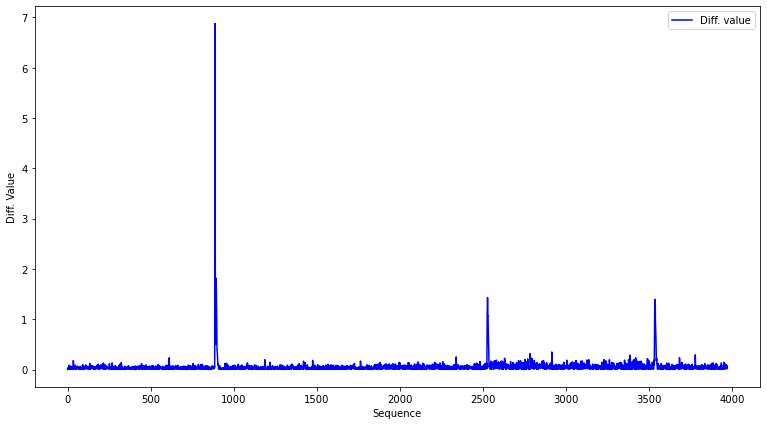

In [25]:
plt.plot(diff_data_list,color = 'blue', label = 'Diff. value')
plt.xlabel('Sequence')
plt.ylabel('Diff. Value')
plt.legend()

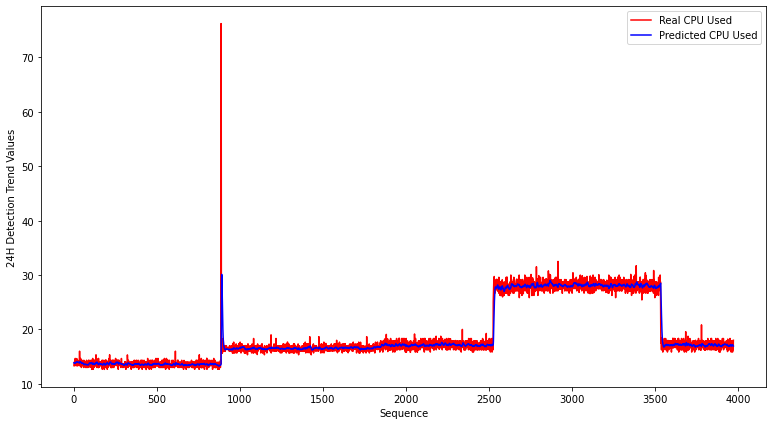

In [26]:
from matplotlib.animation import FuncAnimation

plt.plot(Orgin_data[60:],color = 'red', label = 'Real CPU Used')
plt.plot(pred_value,color = 'blue', label = 'Predicted CPU Used')
plt.xlabel('Sequence')
plt.ylabel('24H Detection Trend Values')
plt.legend()